# Features test

In [70]:
from pathlib import Path
import random
import json
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from data.contours import read_annotations, get_contour_image
from data.contours.instance_masker import InstanceMasker
from data.images.wsi_reader import WSIReader

In [2]:
pd.__version__

'1.0.0'

In [3]:
data_dir = Path('/mnt/rescomp/projects/TCGA_prostate/TCGA')
features_dir = Path('/mnt/rescomp/projects/TCGA_prostate/TCGA/data/features/mpp0.4_active_learn_14f')
slide_id = 'TCGA-2A-AAYF-01Z-00-DX1.D0ADEB9A-37A4-451C-B91C-4AB014A6857A'
#slide_id = 'TCGA-2A-A8W3-01Z-00-DX1.CC00522F-8A47-4C63-B9CC-F215F9EAAFBA'
with open(features_dir/(slide_id + '.json'), 'r') as feature_file:
    features = pd.read_json(feature_file, orient='split')
# NOT BUILDING INDEX CORRECTLY
with open(features_dir/(slide_id + '.json'), 'r') as feature_file:
    feats_= json.load(feature_file)
features.index = feats_['index']

In [4]:
features.index

Index(['28811_70607_525_111', '38051_70563_649_155', '37415_70563_381_155',
       '47131_70531_381_187', '33207_70515_841_203', '57863_70493_779_225',
       '51227_70479_1319_239', '49161_70419_351_299', '46637_70419_351_299',
       '42573_70403_239_135',
       ...
       '26761_15267_811_637', '20635_15235_221_241', '62575_15143_305_301',
       '19393_14983_117_151', '39239_14929_541_359', '70131_14823_177_145',
       '61687_14807_145_225', '59403_14347_205_225', '16681_14347_143_145',
       '14047_14347_269_257'],
      dtype='object', length=5294)

In [5]:
with open(features_dir/(slide_id + '.json'), 'r') as feature_file:
    feats_= json.load(feature_file)

In [6]:
all(a == b for a, b in zip(feats_['index'],list(features.index)))

True

In [7]:
features.index = feats_['index']

In [8]:
features.index

Index(['28811_70607_525_111', '38051_70563_649_155', '37415_70563_381_155',
       '47131_70531_381_187', '33207_70515_841_203', '57863_70493_779_225',
       '51227_70479_1319_239', '49161_70419_351_299', '46637_70419_351_299',
       '42573_70403_239_135',
       ...
       '26761_15267_811_637', '20635_15235_221_241', '62575_15143_305_301',
       '19393_14983_117_151', '39239_14929_541_359', '70131_14823_177_145',
       '61687_14807_145_225', '59403_14347_205_225', '16681_14347_143_145',
       '14047_14347_269_257'],
      dtype='object', length=5294)

In [9]:
slide_contours = read_annotations(data_dir, (slide_id,), 'mpp0.4_active_learn_14f')[slide_id]
masker = InstanceMasker(slide_contours, 'epithelium', dict((('epithelium', 200), ('lumen', 250))))

In [82]:
# TODO match boxes in features and boxes in masker, and check features for desired masks
index_matches = []
i = 0
outer_bounding_boxes = [cv2.boundingRect(outer_contour) for outer_contour in masker.outer_contours]
for box_id, data in features.iterrows():
    box_ = tuple(int(d) for d in box_id.split('_'))
    for j, box in enumerate(outer_bounding_boxes):
        if box_ == box:
            index_matches.append(j)
            break
    i += 1
print(len(index_matches))

5294


In [83]:
random.seed(42)
num_examples = 20
examples = [index_matches[random.randint(0, len(index_matches) - 1)] for i in range(num_examples)]

In [84]:
normalized_features = (features - features.min())/(features.max() - features.min())
print(normalized_features.shape)

(5294, 100)


outer_hu_moment0                             0.075209
outer_hu_moment1                             0.012389
outer_hu_moment2                             0.000393
outer_hu_moment3                             0.000242
outer_hu_moment4                             0.001448
                                               ...   
gray_correlation_d20_a2.356194490192345      0.490579
gray_correlation_d100_a0                     0.475230
gray_correlation_d100_a0.7853981633974483    0.234252
gray_correlation_d100_a1.5707963267948966    0.248181
gray_correlation_d100_a2.356194490192345     0.329610
Name: 28811_70607_525_111, Length: 100, dtype: float64
outer_hu_moment0                             0.081462
outer_hu_moment1                             0.013830
outer_hu_moment2                             0.000090
outer_hu_moment3                             0.000047
outer_hu_moment4                             0.001448
                                               ...   
gray_correlation_d20_a2.356

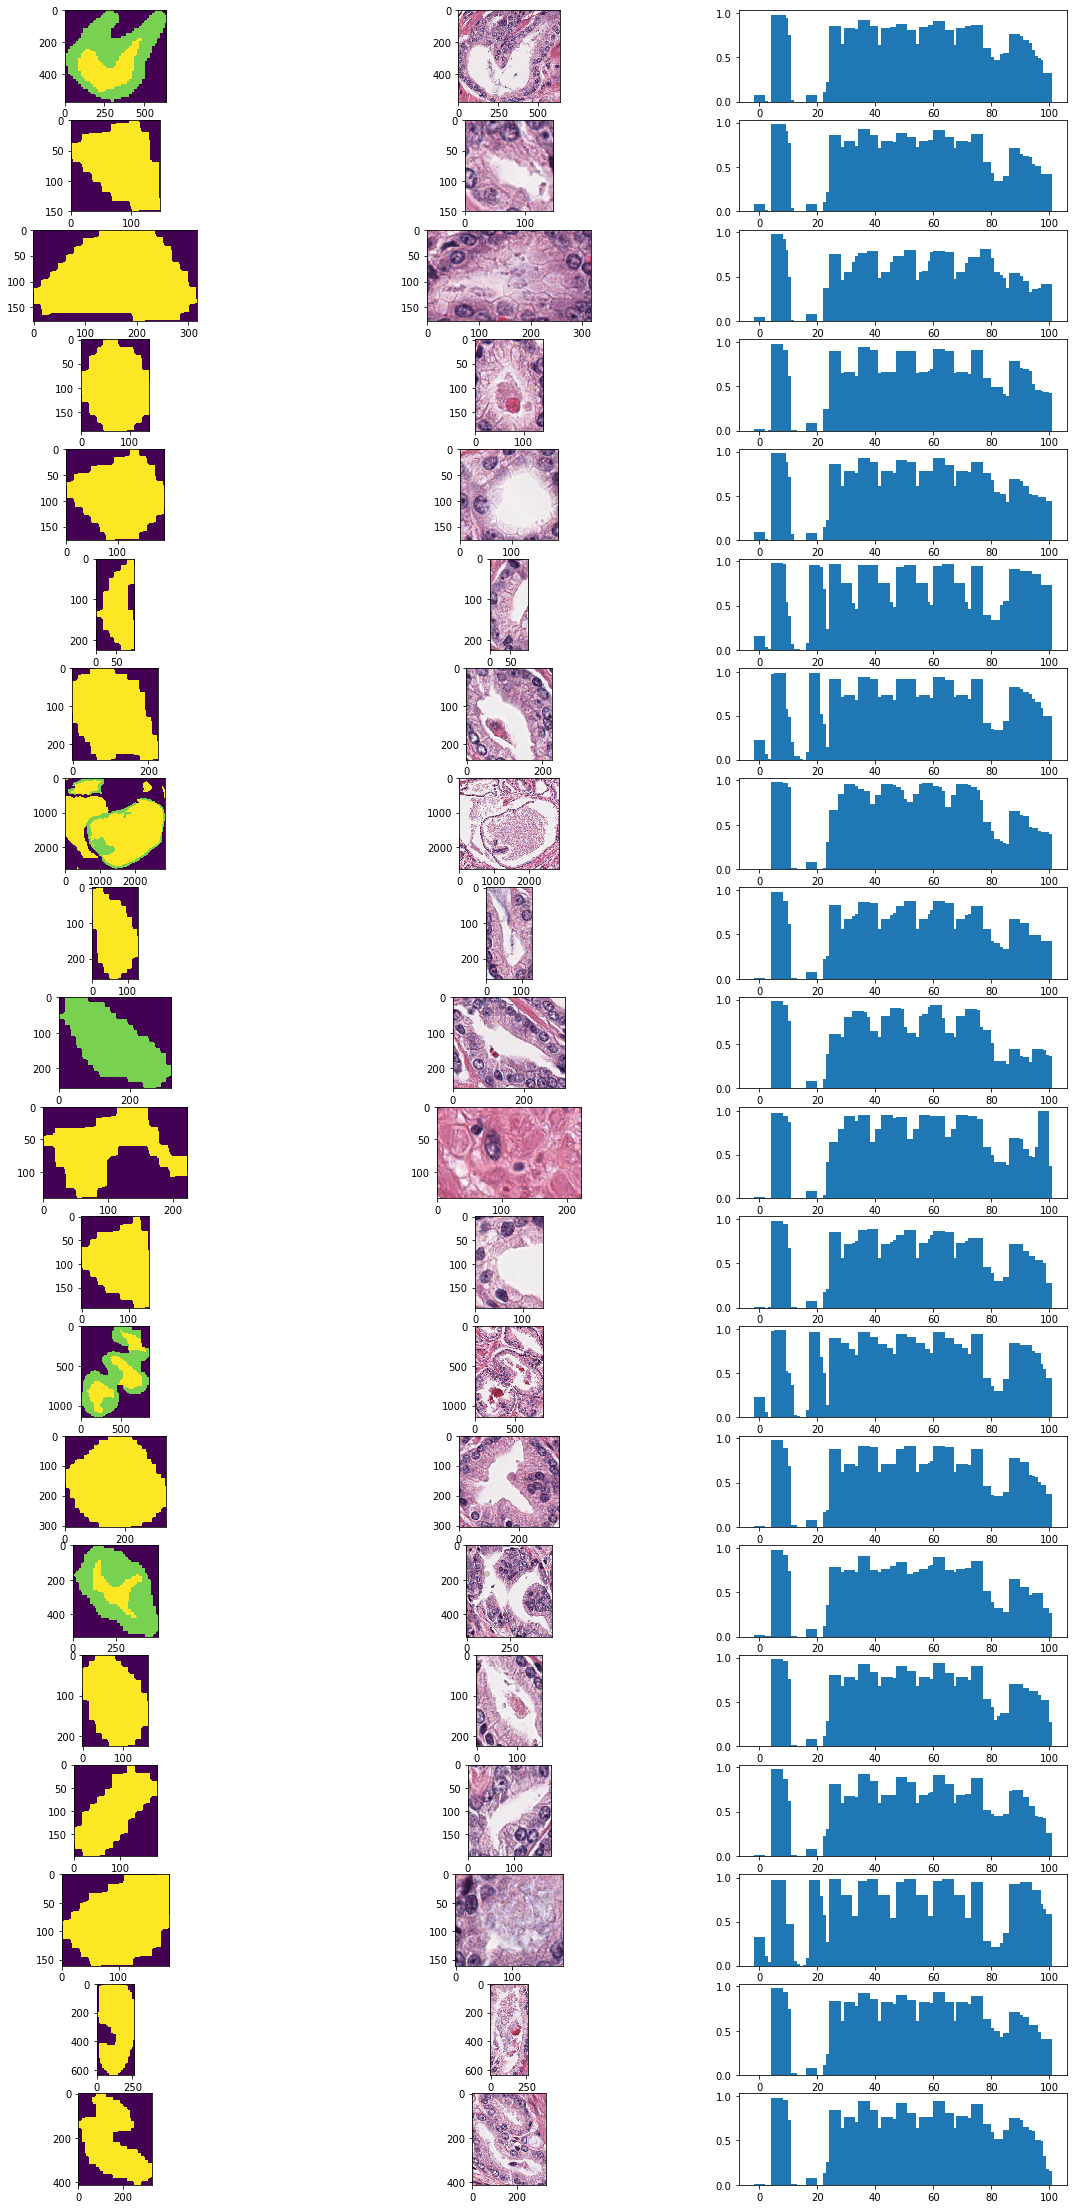

In [86]:
fig, axes = plt.subplots(num_examples, 3, figsize=(20, 40))
slide_path = next(data_dir.glob(f'*/{slide_id}.svs'))
slide = WSIReader(slide_path)
for i, j in enumerate(examples):
    mask, components = masker[j]
    image = get_contour_image(masker.outer_contours[j], slide)
    example_features = normalized_features.iloc[i, :]
    axes[i, 0].imshow(mask)
    axes[i, 1].imshow(image)
    axes[i, 2].bar(np.arange(0, len(example_features)), example_features, 4)  # why is the max 2 when I normalised the features?